#Before we start 

This notebook was created using Google Colab, with Version 5.10.147+ of the platform and Python Version 3.9.16. Any additional packages installed in this notebook are compatible with these versions.

In [ ]:
pip install geopandas 

In [ ]:
pip install contextily

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import requests
import os
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

#Task 1: Data Download

Bonus 1: Allow different values to be passed as parameters through command line interface when running the script.

Note : The parameter selected for this run is to: agency = 'HPD'.

Note : <br>For this data challenge, the number of rows downloaded is capped at 50,000 records, which makes it easier to rerun the analysis and fix any potential issues. 
<br>In this demonstration, the parameter is set to 'agency = HPD'.

In [47]:
from datetime import datetime
# Get agency value from user input
agency = input("Enter agency value: ")

# Set API endpoint URL
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

# Set query parameters
query_params = {
    "$limit": 50000,
    "$where": "created_date >= '{}' and agency = '{}'".format((datetime.now() - timedelta(days=7)).strftime('%Y-%m-%dT%H:%M:%S'), agency)
}

# Make API request
response = requests.get(url, params=query_params)

# Convert JSON response to pandas DataFrame
df = pd.read_json(response.text)

# Create 'data' folder if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

Enter agency value: HPD


Store dataframe to 'data' folder.

In [48]:
df.to_csv("data/raw.csv", index=False)

A quick loof of raw.csv: 

In [49]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,closed_date
0,57217592,2023-04-03T23:55:54.000,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,MOLD,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
1,57217587,2023-04-03T23:55:54.000,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
2,57219780,2023-04-03T23:55:53.000,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
3,57219154,2023-04-03T23:55:53.000,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
4,57213772,2023-04-03T23:55:53.000,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      10002 non-null  int64  
 1   created_date                    10002 non-null  object 
 2   agency                          10002 non-null  object 
 3   agency_name                     10002 non-null  object 
 4   complaint_type                  10002 non-null  object 
 5   descriptor                      10002 non-null  object 
 6   location_type                   10002 non-null  object 
 7   incident_zip                    10002 non-null  int64  
 8   incident_address                10002 non-null  object 
 9   street_name                     10002 non-null  object 
 10  address_type                    10002 non-null  object 
 11  city                            10002 non-null  object 
 12  status                          

#Task 2: Data Aggregation via Python

In [51]:
# Read CSV file into pandas DataFrame
df = pd.read_csv("data/raw.csv")

# Convert created_date column to datetime
df['created_date'] = pd.to_datetime(df['created_date'])

# Create new columns for date and hour
df['created_date_hour'] = df['created_date'].dt.floor('h')
df['complaint_type'] = df['complaint_type'].str.strip()

# Group by created_date_hour and complaint_type, and count the number of complaints
ts_df = df.groupby(['created_date_hour', 'complaint_type']).size().reset_index(name='count')

Store dataframe to 'data' folder.

In [52]:
ts_df.to_csv("data/time_series.csv", index=False)

A quick loof of time_series.csv: 

In [53]:
ts_df.head()

,created_date_hour,complaint_type,count
0,2023-03-29 05:00:00,HEAT/HOT WATER,12
1,2023-03-29 05:00:00,PAINT/PLASTER,2
2,2023-03-29 05:00:00,PLUMBING,1
3,2023-03-29 05:00:00,SAFETY,1
4,2023-03-29 05:00:00,UNSANITARY CONDITION,1


#Task 3: Data Visualization via Python

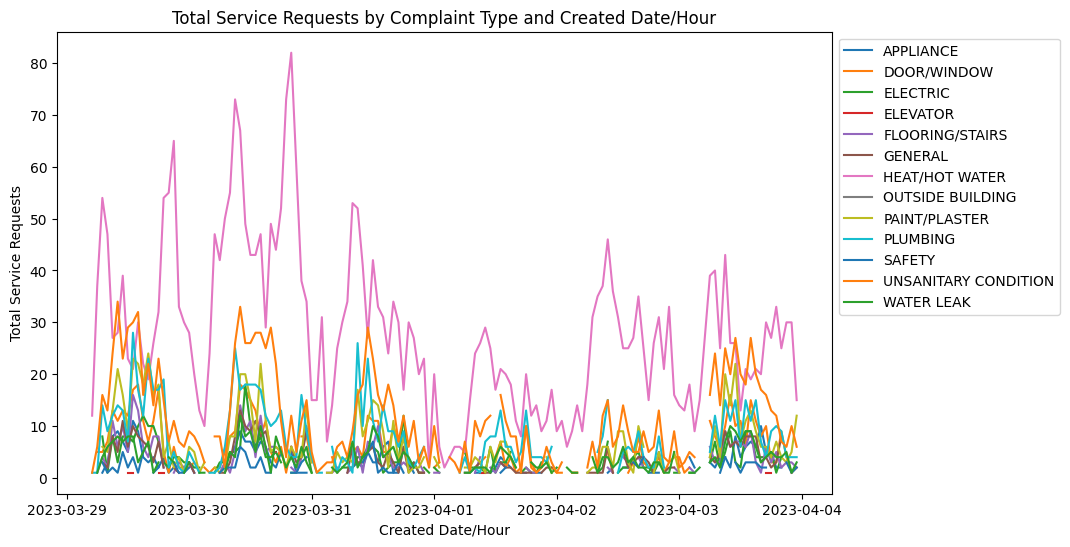

In [54]:
# Convert created_date_hour column to datetime
ts_df['created_date_hour'] = pd.to_datetime(ts_df['created_date_hour'])

# Pivot DataFrame to wide format
pivot_df = ts_df.pivot(index='created_date_hour', columns='complaint_type', values='count')

# Create multi-line plot
plt.figure(figsize=(10, 6))
plt.title("Total Service Requests by Complaint Type and Created Date/Hour")
plt.xlabel("Created Date/Hour")
plt.ylabel("Total Service Requests")
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

Store this image to 'data' folder as a .png file.

In [55]:
plt.savefig("data/service_requests.png")

<Figure size 640x480 with 0 Axes>

#Task4 : Spatial data processing via Python

Requst 2020 NTA (Neighborhood Tabulation Area) boundaries

In [56]:
url = "https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=GeoJSON"

# Make HTTP request
response = requests.get(url)

# Save GeoJSON file to 'data' folder
with open("data/nta.geojson", "wb") as f:
    f.write(response.content)

Read GeoJSON file into geopandas DataFrame.


In [57]:
nta_gdf = gpd.read_file("data/nta.geojson")

Perform spatial data processing.

Note : The parameter selected for this run is complaint_type = 'appliance'.

Explaination :
<br>When performing the spatial join between the NTA and sample_311 datasets, I considered all possible methods that could enable the join. Since both datasets contain point geometry, I ultimately chose to use the 'nearest' method. This ensured that all 311 calls were joined to the nearest ntacode.

Additionally, since the goal was to analyze trends in aggregations within NTAs, the resulting choropleth map provided a visual approximation of which areas had higher aggregates, using warmer colors to highlight those areas.

Finally, in the later SQL task, I found that using this method with spatial SQL conveniently provided the distance between two points. In fact, the average distance between points was within a meter, making it a precise and accurate method for analyzing spatial relationships.

Enter complaint_type value: appliance


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


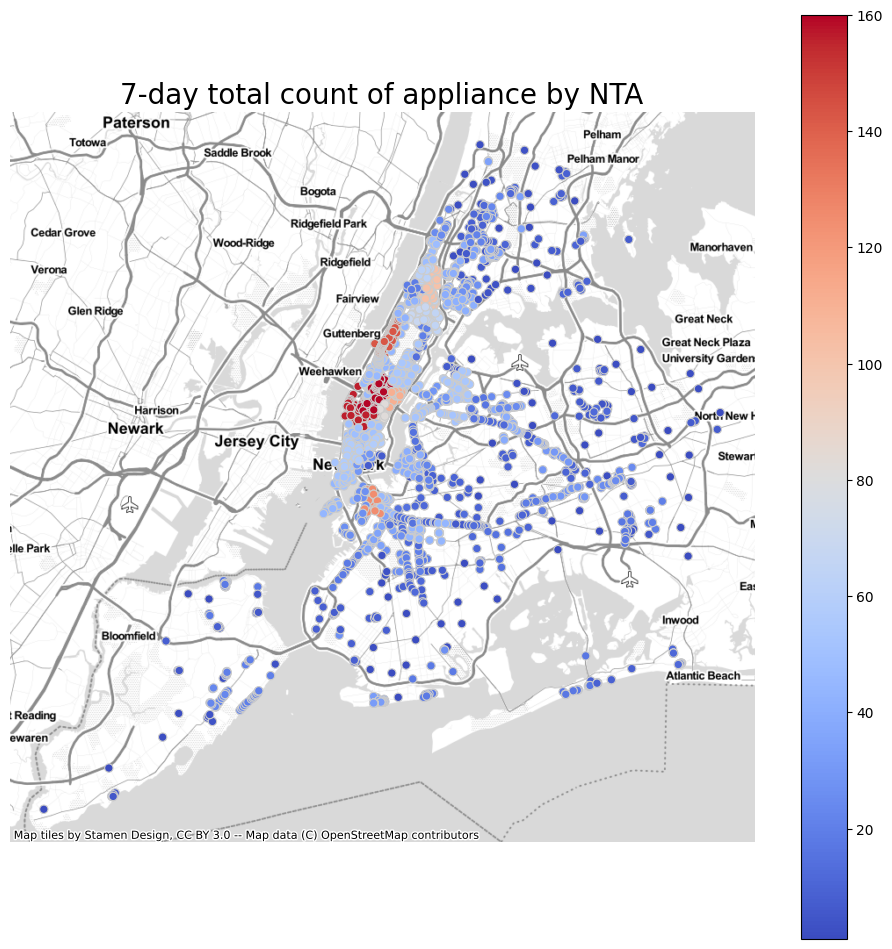

In [58]:
import datetime

# Get user input for complaint type
complaint_type = input("Enter complaint_type value: ")

# Define time window as 7 days ago from current date
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=7)

# Filter the dataset for the given complaint type and time window
filtered_df = df[
    (df['complaint_type'] == complaint_type) &
    (df['created_date'] >= start_date) &
    (df['created_date'] <= end_date)
]

# Convert the filtered DataFrame to a GeoDataFrame and set the CRS
filtered_gdf = gpd.GeoDataFrame(
    filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude)
)
filtered_gdf.crs = nta_gdf.crs

# Perform a spatial join between the filtered GeoDataFrame and the NTA GeoDataFrame using the 'nearest' method
merged_gdf = gpd.sjoin(nta_gdf, filtered_gdf, how='left', op='nearest')

# Aggregate the counts by NTA
incident_counts = merged_gdf.groupby('ntacode').size().reset_index(name='count')

# Merge the counts back to the NTA dataset
nta_with_counts = nta_gdf.merge(incident_counts, on='ntacode', how='left').fillna(0)

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
nta_with_counts_web_mercator = nta_with_counts.to_crs(epsg=3857)

# Create the choropleth map
fig, ax = plt.subplots(1, figsize=(12, 12))
nta_with_counts_web_mercator.plot(column='count', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Remove the axis
ax.axis('off')

# Set the title of the plot
ax.set_title('7-day total count of {} by NTA'.format(complaint_type), fontdict={'fontsize': '20', 'fontweight': '3'})

# Show the plot
plt.show()